# Import libraries

In [1]:
import sys
import os
import glob
import re 
import pandas as pd
import numpy as np
from lxml import etree
import matplotlib.pyplot as plt
import requests
import time
from collections import Counter
import seaborn as sns
import matplotlib
from scipy import stats

import functions

# Import Data

In [2]:
results_df = pd.read_csv("./../data/training_results_century.csv")

In [3]:
results_df

,Name,eval/f1_macro,test:test_f1_macro,dataset_century,dataset_config,dataset_language,State,Notes,User,Tags,...,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,train:epoch,train:train_loss,train:train_runtime,train:train_samples_per_second,train:train_steps_per_second,train_size,validation_size
0,bert-base-multilingual-cased_sequence_genre_lA...,NaN,NaN,19th,genre,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bert-base-multilingual-cased_sequence_division...,NaN,NaN,19th,division,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bert-base-multilingual-cased_sequence_genre_lA...,NaN,NaN,21st,genre,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bert-base-multilingual-cased_sequence_division...,NaN,NaN,20th,division,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bert-base-multilingual-cased_sequence_testamen...,NaN,NaN,20th,testament,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,bert-base-multilingual-cased_sequence_genre_lX...,NaN,NaN,20th,genre,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,bert-base-multilingual-cased_sequence_genre_lX...,NaN,NaN,21st,genre,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,bert-base-multilingual-cased_sequence_testamen...,NaN,NaN,20th,testament,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
532,bert-base-multilingual-cased_sequence_division...,NaN,NaN,20th,division,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
results_df.columns.tolist()[-20:]

['test:test_steps_per_second',
 'test_size',
 'total_steps',
 'total_warmup_steps',
 'train/epoch',
 'train/global_step',
 'train/learning_rate',
 'train/loss',
 'train/total_flos',
 'train/train_loss',
 'train/train_runtime',
 'train/train_samples_per_second',
 'train/train_steps_per_second',
 'train:epoch',
 'train:train_loss',
 'train:train_runtime',
 'train:train_samples_per_second',
 'train:train_steps_per_second',
 'train_size',
 'validation_size']

In [5]:
results_df["dataset_language"]

0      ALB
1      ALB
2      ALB
3      ALB
4      ALB
      ... 
529    XKL
530    XKL
531    XKL
532    XKL
533    XKL
Name: dataset_language, Length: 534, dtype: object

In [6]:
results_df.loc[results_df["dataset_language"] == "ENG", "is_English?"] = True
results_df["is_English?"].fillna(False, inplace=True)

In [7]:
results_df.loc[(results_df["dataset_century"].isin(["21st", '20th'])), "is_contemporary?"] = True
results_df["is_contemporary?"].fillna(False, inplace=True)

In [8]:
results_df.rename(columns={"test:test_f1_macro": "test_f1_macro"}, inplace=True)

In [9]:
results_df.dataset_century = results_df.dataset_century.str.replace("2ndBC-15th", "-2ndBC-15th")

In [10]:
results_df.dataset_century.unique()

array(['19th', '21st', '20th', '16th', '-2ndBC-15th', '18th', '17th'],
      dtype=object)

In [11]:
results_df.loc[results_df["eval/f1_macro"].notna()]

,Name,eval/f1_macro,test_f1_macro,dataset_century,dataset_config,dataset_language,State,Notes,User,Tags,...,train/train_steps_per_second,train:epoch,train:train_loss,train:train_runtime,train:train_samples_per_second,train:train_steps_per_second,train_size,validation_size,is_English?,is_contemporary?
72,bert-base-multilingual-cased_sequence_testamen...,0.938461,0.925433,20th,testament,CHA,finished,-,versae,NaN,...,5.278,3.0,0.254874,235.3275,42.222,5.278,3312.0,455.0,False,True
108,bert-base-multilingual-cased_sequence_division...,0.634938,0.716651,20th,division,DAN,finished,-,versae,NaN,...,6.426,3.0,1.035750,104.5679,51.297,6.426,1788.0,213.0,False,True
114,bert-base-multilingual-cased_sequence_genre_lD...,0.698399,0.675934,20th,genre,DAN,finished,-,versae,NaN,...,5.685,3.0,0.894097,535.5792,45.472,5.685,8118.0,1002.0,False,True
118,bert-base-multilingual-cased_sequence_testamen...,0.969683,0.962048,20th,testament,DAN,finished,-,versae,NaN,...,7.351,3.0,0.170534,441.9528,58.785,7.351,8660.0,1191.0,False,True
126,bert-base-multilingual-cased_sequence_genre_lE...,0.894304,0.892833,21st,genre,ENG,finished,-,versae,NaN,...,4.375,3.0,0.508258,6415.0120,35.002,4.375,74847.0,9385.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,bert-base-multilingual-cased_sequence_genre_lS...,0.761969,0.753274,20th,genre,SWE,finished,-,versae,NaN,...,5.348,3.0,0.776702,1379.3219,42.775,5.348,19667.0,2458.0,False,True
467,bert-base-multilingual-cased_sequence_testamen...,0.935680,0.934982,20th,testament,SWE,finished,-,versae,NaN,...,5.315,3.0,0.267870,1476.5270,42.513,5.315,20924.0,2877.0,False,True
506,bert-base-multilingual-cased_sequence_division...,0.716950,0.723687,21st,division,VIE,finished,-,versae,NaN,...,5.456,3.0,0.920514,144.0584,43.503,5.456,2089.0,269.0,False,True
518,bert-base-multilingual-cased_sequence_testamen...,0.931429,0.937746,21st,testament,VIE,finished,-,versae,NaN,...,5.279,3.0,0.240426,744.4117,42.215,5.279,10475.0,1459.0,False,True


# Hypothesis

## Centuries

In [12]:
results_df

,Name,eval/f1_macro,test_f1_macro,dataset_century,dataset_config,dataset_language,State,Notes,User,Tags,...,train/train_steps_per_second,train:epoch,train:train_loss,train:train_runtime,train:train_samples_per_second,train:train_steps_per_second,train_size,validation_size,is_English?,is_contemporary?
0,bert-base-multilingual-cased_sequence_genre_lA...,NaN,NaN,19th,genre,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,bert-base-multilingual-cased_sequence_division...,NaN,NaN,19th,division,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,bert-base-multilingual-cased_sequence_genre_lA...,NaN,NaN,21st,genre,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,bert-base-multilingual-cased_sequence_division...,NaN,NaN,20th,division,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
4,bert-base-multilingual-cased_sequence_testamen...,NaN,NaN,20th,testament,ALB,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,bert-base-multilingual-cased_sequence_genre_lX...,NaN,NaN,20th,genre,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
530,bert-base-multilingual-cased_sequence_genre_lX...,NaN,NaN,21st,genre,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
531,bert-base-multilingual-cased_sequence_testamen...,NaN,NaN,20th,testament,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
532,bert-base-multilingual-cased_sequence_division...,NaN,NaN,20th,division,XKL,finished,-,versae,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


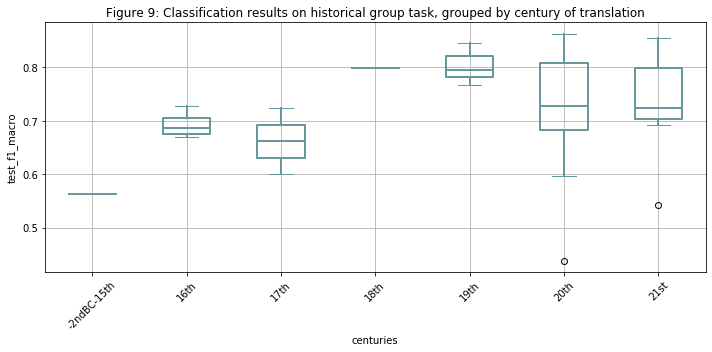

In [13]:
functions.plot_boxplots_by(results_df.loc[(results_df["test_f1_macro"].notna()) & (results_df["dataset_config"] == "division")], "test_f1_macro", "dataset_century",
rot = 45, xlabel = "centuries", ylabel = "test_f1_macro",
title = "Figure 9: Classification results on historical group task, grouped by century of translation",
figure_name = "figure9_classification_centuries",
figsize=(10,5))

### Genre

In [34]:
functions.test_differences_columns(results_df.loc[(results_df["dataset_config"]=="genre") & (results_df["test_f1_macro"].notna())], "is_contemporary?", "test_f1_macro").round(3)


,value1,value2,pvalue,statistic,mean_value_1,mean_value_2,significance
0,False,True,0.634,-0.481,0.756,0.771,


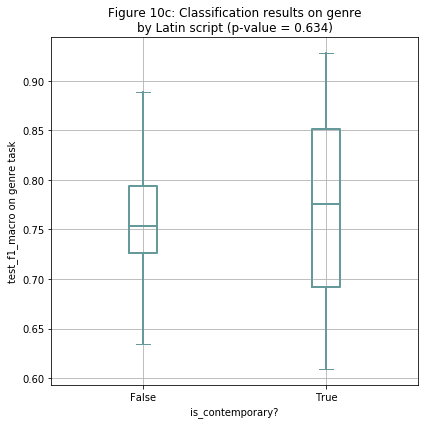

In [19]:
functions.plot_boxplots_by(results_df.loc[(results_df["dataset_config"]=="genre") & (results_df["test_f1_macro"].notna())],
"test_f1_macro", "is_contemporary?",
title = "Figure 10c: Classification results on genre\nby Latin script (p-value = 0.634)",
xlabel = "is_contemporary?", ylabel = "test_f1_macro on genre task",
figure_name = "figure10c_classification_genre_contemporary", figsize = (6,6),
)

### Group of Texts

In [36]:
functions.test_differences_columns(results_df.loc[(results_df["dataset_config"]=="division") & (results_df["test_f1_macro"].notna())], "is_contemporary?", "test_f1_macro").round(3)



,value1,value2,pvalue,statistic,mean_value_1,mean_value_2,significance
0,False,True,0.823,-0.226,0.715,0.724,


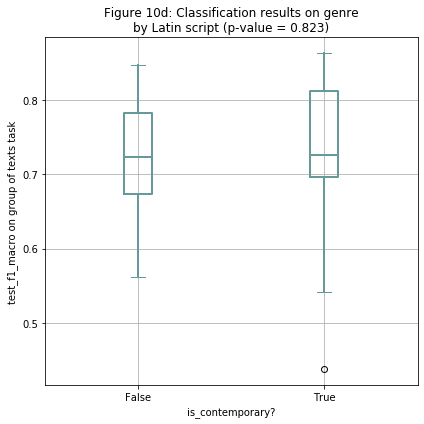

In [18]:
functions.plot_boxplots_by(results_df.loc[(results_df["dataset_config"]=="division") & (results_df["test_f1_macro"].notna())],
"test_f1_macro", "is_contemporary?",
title = "Figure 10d: Classification results on genre\nby Latin script (p-value = 0.823)",
xlabel = "is_contemporary?", ylabel = "test_f1_macro on group of texts task",
figure_name = "figure10d_classification_division_contemporary", figsize = (6,6),
)

### Testament

In [39]:
functions.test_differences_columns(results_df.loc[(results_df["dataset_config"]=="testament") & (results_df["test_f1_macro"].notna())], "is_contemporary?", "test_f1_macro").round(3)



,value1,value2,pvalue,statistic,mean_value_1,mean_value_2,significance
0,False,True,0.802,0.253,0.947,0.945,


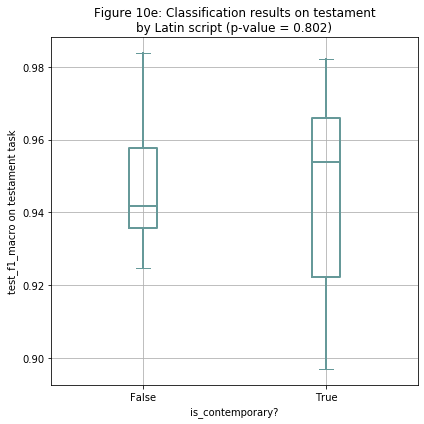

In [17]:
functions.plot_boxplots_by(results_df.loc[(results_df["dataset_config"]=="testament") & (results_df["test_f1_macro"].notna())],
"test_f1_macro", "is_contemporary?",
title = "Figure 10e: Classification results on testament\nby Latin script (p-value = 0.802)",
xlabel = "is_contemporary?", ylabel = "test_f1_macro on testament task",
figure_name = "figure10e_classification_testament_contemporary", figsize = (6,6),
)